In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from E_model import model, show_plot

In [6]:
num_samples = 1000
sigma_big = 0.2
sigma_small = 0.01
p = [0.4597, 1.1255, 0.6814, 0.0094, 0.1913]

Yxs_dist = np.random.normal(p[0], sigma_big, num_samples)
qs_max_dist = np.random.normal(p[1], sigma_big, num_samples)
Ks_dist = np.random.normal(p[2], sigma_big, num_samples)
m_s_dist = np.random.normal(p[3], sigma_small, num_samples)
lag_dist = np.random.normal(p[4], sigma_small, num_samples)

df_p = pd.DataFrame({
    'Yxs': Yxs_dist,
    'qs_max': qs_max_dist,
    'Ks': Ks_dist,
    'm_s': m_s_dist,
    'lag': lag_dist
})
df_p.describe()

,Yxs,qs_max,Ks,m_s,lag
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.453020,1.140706,0.684627,0.009451,0.191422
std,0.198661,0.194153,0.210138,0.009895,0.010252
min,-0.082719,0.462435,0.053301,-0.018878,0.157282
25%,0.313753,0.999602,0.540636,0.002734,0.184695
50%,0.457904,1.145344,0.688544,0.009647,0.191331
75%,0.589296,1.275969,0.818238,0.016237,0.197965
max,1.043600,1.875849,1.325313,0.041328,0.229118


In [3]:
list_p = list(df_p.iloc[0])
list_p

[0.151992810576842,
 1.0913905875155927,
 0.7009192765378626,
 0.011957120408883772,
 0.19782139782595307]

In [ ]:
df_batches = pd.DataFrame(columns=['time', 'biomass', 'glucose', 'batch_id'])
for i in range(df_p.shape[0]):
    batch_id = str(i).zfill(3)
    list_p = list(df_p.iloc[i])
    df = model(list_p)
    df['batch_id'] = str(batch_id)
    # show_plot(df)
    df_batches = pd.concat([df_batches, df], ignore_index=True)

df_batches.to_csv('data/generated data/df_gen.csv')

In [ ]:
df_gen = pd.read_csv('data/generated data/df_gen.csv')
df_gen['batch_id'] = df_gen['batch_id'].astype(str).str.zfill(3)

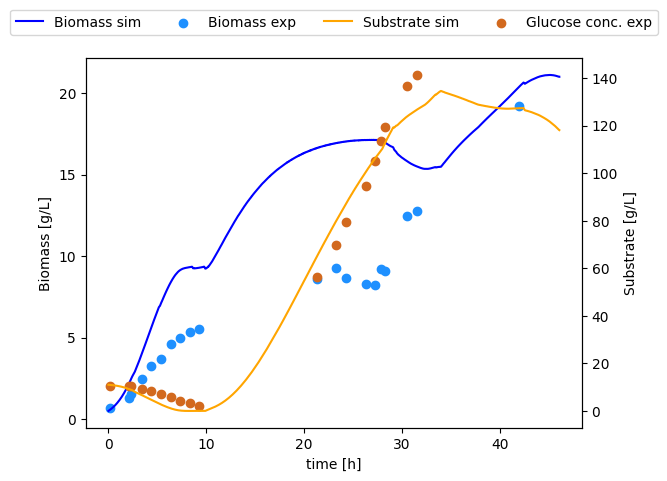

In [ ]:
df_one = df_gen[df_gen['batch_id'] == '007']
show_plot(df_one)

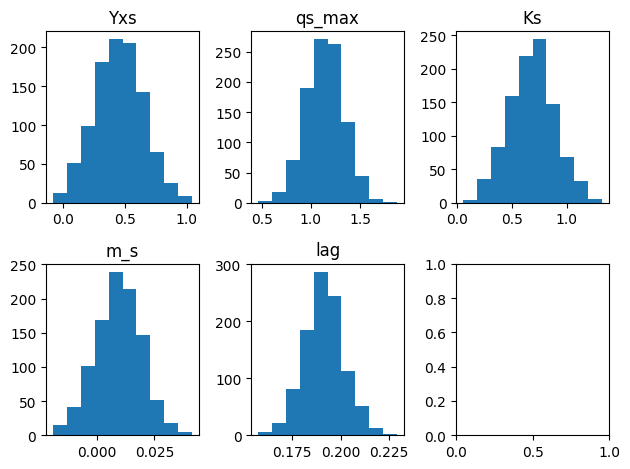

In [7]:
fig, ax = plt.subplots(2, 3)
ax[0,0].hist(df_p['Yxs'])
ax[0,0].set_title('Yxs')
ax[0,1].hist(df_p['qs_max'])
ax[0,1].set_title('qs_max')
ax[0,2].hist(df_p['Ks'])
ax[0,2].set_title('Ks')
ax[1,0].hist(df_p['m_s'])
ax[1,0].set_title('m_s')
ax[1,1].hist(df_p['lag'])
ax[1,1].set_title('lag')
plt.tight_layout()